"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
import numpy as np
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
sys.path.append('/media/bigdata/firing_space_plot/changepoint_mcmc/v2')
from ephys_data import ephys_data
from changepoint_io import fit_handler

In [21]:
fit = 40000
samples = 20000

data_dir = '/media/bigdata/Abuzar_Data/bla_gc/AM11/AM11_4Tastes_191029_171714'
taste_num = 0
region_name = 'gc'
experiment_name = 'single_taste_poisson'

model_parameters = dict(zip(['states','fit','samples'],[4,40000,20000]))
preprocess_parameters = dict(zip(['time_lims','bin_width','data_transform'],
                                [[2000,4000],50, None]))

fit_handler_kwargs = {'data_dir' : data_dir,
                    'taste_num' : taste_num,
                    'region_name' : region_name,
                    'experiment_name' : experiment_name}
handler = fit_handler(**fit_handler_kwargs)
handler.set_model_params(**model_parameters)
handler.set_preprocess_params(**preprocess_parameters)

MODEL_PARAMS will have to be set
PREPROCESS_PARAMS will have to be set


In [4]:
handler.preprocess_data()

Loading spike trains from AM11_4Tastes_191029_171714, dig_in 0
Preprocessing spike trains, preprocessing func: <preprocess_single_taste>


In [5]:
handler.preprocessed_data.shape

(30, 8, 40)

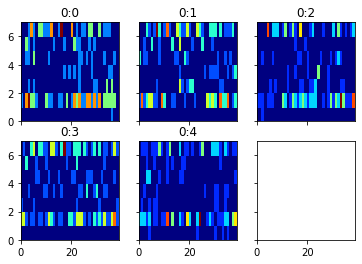

In [6]:
trial_count = 5
trial_inds = np.random.choice(np.arange(handler.preprocessed_data.shape[0]),5)
visualize.firing_overview(handler.preprocessed_data[trial_inds]);

data_array = handler.preprocessed_data

In [7]:
states = model_parameters['states']
nrns = data_array.shape[1]
trials = data_array.shape[0]
idx = np.arange(data_array.shape[-1])
length = len(idx)
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_array,states,axis=-1)]).T
mean_vals = np.mean(mean_vals,axis=1)
print(mean_vals.shape)

(8, 4)


In [8]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = 2
    #b_lambda = 5
    #lambda_latent = pm.Beta('lambda', 
    #                                a_lambda, b_lambda, 
    #                                shape = (nrns,states),
    #                              testval = mean_vals + 1e-3)
    
    lambda_latent = pm.Exponential('lambda',                                 
                                        1/mean_vals,                                 
                                       shape = (nrns,states))

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [9]:
print(tau.tag.test_value.shape)

(30, 3)


In [10]:
print(idx.shape)

(40,)


In [11]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((trials,1,length))],axis=1)

    weight_stack = np.multiply(weight_stack,inverse_stack)

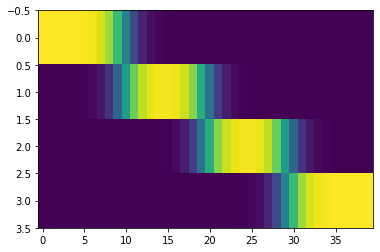

In [12]:
plt.imshow(weight_stack.tag.test_value[0],aspect='auto');

In [13]:
print(weight_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(30, 4, 40)
(8, 4)


In [14]:
with model:
    lambda_ = tt.tensordot(weight_stack,lambda_latent, [1,1]).swapaxes(1,2)
    #lambda_ = lambda_latent.dot(weight_stack)
print(lambda_.tag.test_value.shape)

(30, 8, 40)


In [15]:
# visualize.firing_overview(true_r,cmap='viridis')
# plt.figure()
# visualize.firing_overview(lambda_.tag.test_value, cmap='viridis')
# print(true_r.shape)
# print(lambda_.tag.test_value.shape)

In [16]:
with model:
    # Add observations
    #observation = pm.Bernoulli("obs", lambda_, observed=data_array)
    observation = pm.Poisson("obs", lambda_, observed=data_array)

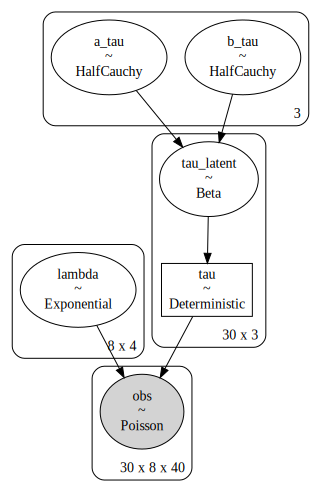

In [17]:
pm.model_to_graphviz(model)

In [19]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

Finished [100%]: Average Loss = 6,753.1


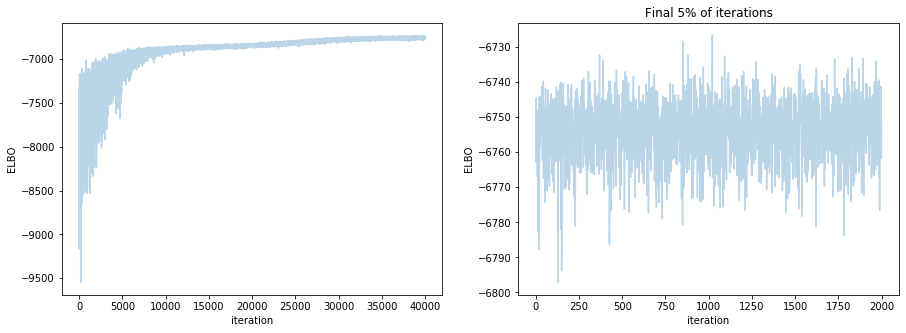

In [22]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [23]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [24]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)

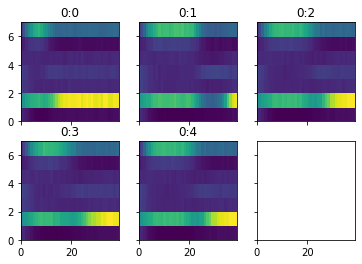

In [26]:
#visualize.firing_overview(true_r[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [27]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(20000, 30, 3)
(30, 3)


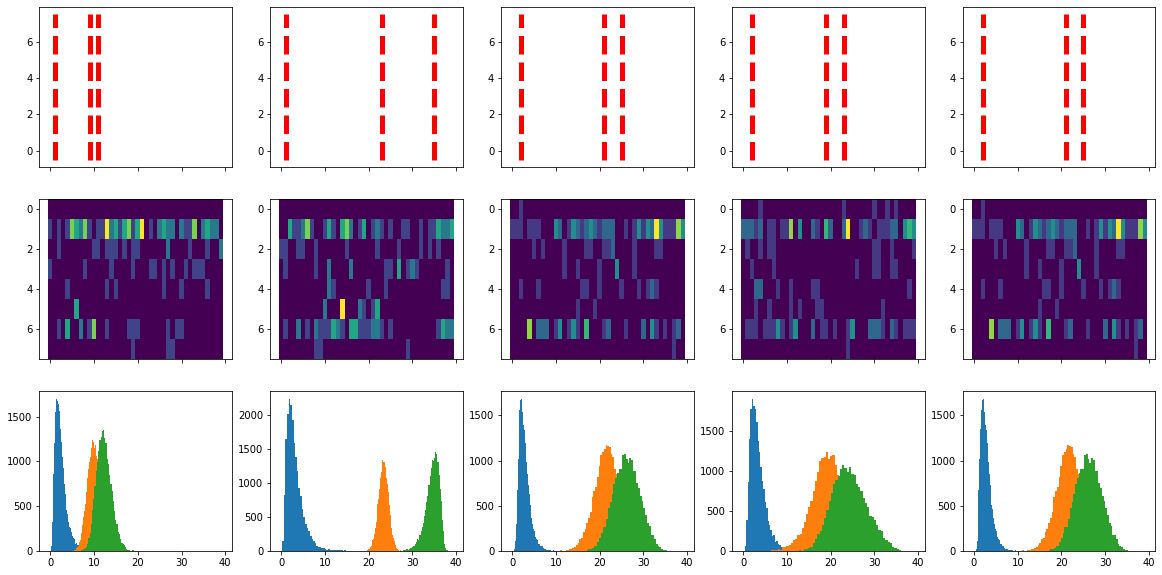

In [29]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    #ax[0,trial_num].imshow(true_r[this_trial_ind],aspect='auto')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')